In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F

# <center>Deep Generative Models</center>
## <center>Seminar 1</center>

<center><img src="pics/ozonmasterslogo.png" width=600 height=600 /></center>
<center>10.02.2021</center>


### Kondratenko Vladimir


tg: @username27

e-mail: vladimir.kondratenko@phystech.edu

## Plan

- Maximum Likelihood Estimation
- Example of a simple 1D/2D distribution
- MADE
- Masked Linear Layer

## Maximum Likelihood Estimation (MLE)

What do we want?

We have samles $X \sim \pi(x)$. We assume what $\pi(x) \approx p(x|\theta)$. So, let's get $\theta$ estimation using $X$

How?

$\theta^* = argmax_{\theta} p(X | \theta) = argmax_{\theta} \prod_{i=1}^n p(x_i | \theta) = argmax_{\theta} \sum_{i=1}^n \log p(x_i | \theta)$

## MLE examlpes

### Example 1

$X_1, ... X_n \sim U[0,\theta]$. 

$\hat{\theta}_{MLE} = ?$

For a single $x \sim U[0,\theta]$:

$f(x) = \dfrac{1}{\theta}, x \in [0,\theta]$

$f(x) = 0, x \notin [0,\theta]$

We have $X_1, ... X_n \sim U[0,\theta]$:

$f(X | \theta) = \dfrac{1}{\theta^{n}}, X \in [0,\theta]^{n}$, and $0, X \notin [0,\theta]^{n}$

It also can be written as:

$f(X | \theta) = \dfrac{1}{\theta^{n}}, max(X_1, ... X_n) \leq \theta$, and $0, max(X_1, ... X_n) > \theta$

So, we can find:

$\hat{\theta}_{MLE} = max(X_1, ... X_n)$

$\hat{\theta}_{MLE} = max(X_1, ... X_n)$ is also random variable

How does Cumulative distribution function $F(x) = P(x < X)$ looks like?


$P_{X \sim U[0,\theta]}(max(X_1, ... X_n) < x) = \dfrac{x^n}{\theta^n}$, $x \in [0,\theta]$

$\hat{\theta}$ is **unbiased** estimation of $\theta$: $\mathbb{E}\hat{\theta} = \theta$.

Are MLEs **unbiased**?

Let's find this $\mathbb{E}\hat{\theta}_{MLE} = ?$

We know that:

$\mathbb{E}x = \int_{-\infty}^{+\infty} x f(x) dx = \int_{-\infty}^{+\infty} x dF(x)$


$P_{X \sim U[0,\theta]}(max(X_1, ... X_n) < x) = \dfrac{x^n}{\theta^n}$, $x \in [0,\theta]$

$\mathbb{E}_{X \sim U[0,\theta]}\hat{\theta}_{MLE} =
\int_{0}^{\theta} x d \dfrac{x^n}{\theta^n} = ...
%\int_{0}^{\theta} \dfrac{xnx^{n-1}}{\theta^n} d x =
%\int_{0}^{\theta} \dfrac{nx^{n}}{\theta^n} d x =
%\dfrac{n\theta^{n+1}}{(n+1)\theta^n}$

$\Rightarrow \mathbb{E}_{X \sim U[0,\theta]}\hat{\theta}_{MLE} = \dfrac{n}{n+1}\theta \Rightarrow$ MLE is not **unbiased**

### MLE

- not unbiased
- consistent (состоятельные)
- asymptotically efficient (асимптотически эффективные)
- asymptotically normal (асимптотически нормальные)

## Simple distributions
### Example 1

Let we have samples $X \sim \pi(x)$ and want approximate $\pi(x)$

In [2]:
def generate_1d_data(count, bins):
    np.random.seed(42)
    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)
    mask = np.random.rand(count) < 0.5
    samples = (a * mask + b * (1 - mask)) * (bins - 1)
    data = np.clip(samples.astype('int'), 0.0, (bins - 1))
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

In [3]:
def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()

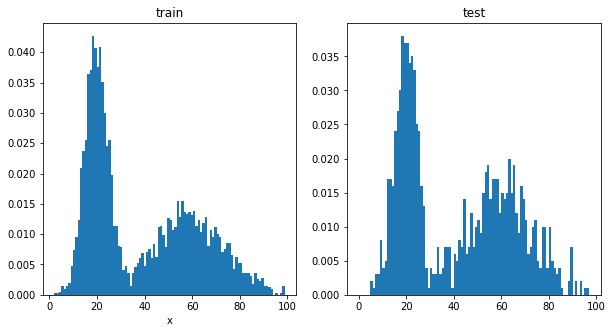

In [4]:
BINS = 100
COUNT = 5000

train_data, test_data = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

How we can do it?

We can assume what $\pi(k) \approx p(k|\theta)$ and try to optimize $\theta$. For example $p(k|\theta) = \dfrac{e^{\theta_k}}{\sum\limits_{i=1}^{d}e^{\theta_i}}$

Let $X$ has $n_i$ elements equal to $i$, $\sum\limits_{i=1}^{d}n_i = N$. Loglikelihood: 

$log~p(X|\theta) =\sum\limits_{i=1}^{d} n_i log~p(k=i|\theta)$

For batch of $\{x_i\}_{i=1}^{N}$ elements and predicted probabilities $\{(p^1_i, \dots , p^d_i)\}_{i=1}^{N}$:

Cross entropy loss = $- \sum\limits_{i=1}^{N} x_i log~p_{i}^{x_i}$

### Example 2

Let we have samples from 2D distribution. We want to generate additional samples from the distribution 

In [8]:
def generate_2d_data(count, bins):
    im = Image.open('pics/sem_image.png').resize((bins, bins)).convert('L')
    im = np.array(im).astype('float32')
    dist = im / im.sum()

    pairs = list(itertools.product(range(bins), range(bins)))
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    samples = np.array([pairs[i] for i in idxs])

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]

In [9]:
def plot_2d_data(train_data, test_data, bins=None):
    if bins is None:
        bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    else:
        bins = int(bins)
    train_dist, test_dist = np.zeros((bins, bins)), np.zeros((bins, bins))
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()

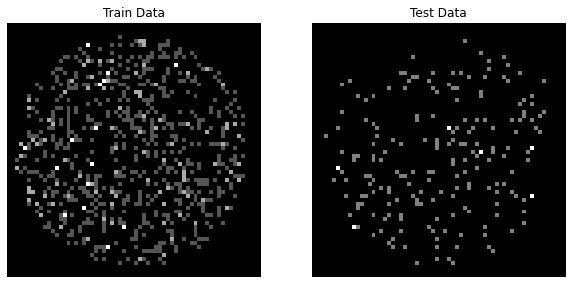

In [10]:
COUNT = 1000
BINS = 64

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data, BINS)

## MADE

<img src="pics/made.png" width=600 height=600 />

- What is model's input and output?
- What loss fuction should we optimize? How?
- Tensors' shapes?

- How do connections between inputs and outputs look like?

- How can we train MNIST?

### Masks in MADE
Pytorch docs
<img src="pics/linear.jpg" width=600 height=600 />

In [11]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * (self.weight*0+1), self.bias*0)#+torch.Tensor(np.arange(self.out_features))*0.1)

In [12]:
mask = np.concatenate([np.ones((2,8)), np.zeros((2,8))], axis=0)
#mask = np.hstack([np.ones((4,4)), np.zeros((4,4))])

ml_layer = MaskedLinear(4,8)
ml_layer.set_mask(mask)

inp = [1,2,3,4]
inp = torch.Tensor([inp,inp])+np.array([0,10])[:,None]

In [11]:
ml_layer(inp.float())